In [1]:
%matplotlib inline

import os
import sys
import json
import logging
import warnings
warnings.filterwarnings('ignore')

# 更改为自己的路径,或者直接在环境变量中添加
sys.path.append('/Users/zhenwei.jin/Documents/repos/genie')

import pandas as pd
import numpy as np
from jinja2 import Template

#python3种reload函数不能直接使用
from imp import reload

from utils3.data_io_utils import *
import utils3.misc_utils as mu
import utils3.summary_statistics as ss
import utils3.metrics as mt
import utils3.feature_selection as fs
import utils3.plotting as pl
import utils3.modeling as ml
from functools import reduce
import xgboost as xgb
import utils3.verify_performance as vp

# 设置工作路径

In [2]:
DATA_PATH='/Users/zhenwei.jin/Desktop/sample_weight/xgboost/02_data'
RESULT_PATH='/Users/zhenwei.jin/Desktop/sample_weight/xgboost/03_result/'

# 读取建模字典

In [3]:
var_dict=pd.read_excel(DATA_PATH+'/建模字典.xlsx')

# 读取建模数据

注该样本已完成数据格式和缺失值的填充,若未完成,需要提前做好。

In [4]:
all_x_y=load_data_from_pickle(DATA_PATH,'抽样建模DEMO.pkl')

In [5]:
all_x_y.index=all_x_y.apply_id

## 增加sample_weight

sample_weight的添加方式，建议结合自身的抽样情况决定。

In [6]:
segment_label='channel_class'
sample_weight_model={'Bad Channel':{'good_sample':7.46,'bad_sample':2.43},\
               'Good Channel':{'good_sample':6.42,'bad_sample':1},\
              'Normal Channel':{'good_sample':20.79,'bad_sample':3.19}}

In [7]:
model_data=all_x_y[all_x_y['sample_set']!='OOT']

In [8]:
model_data=mt.BinWoe().add_sample_weight(model_data,segment_label,sample_weight_model)

# 整理X,y,sample_weight数据

In [9]:
X=model_data[var_dict[u'指标英文']]
y=model_data['y']
sample_weight=model_data['sample_weight']

# EDA

## 不包含sample_weight

In [10]:
ss.eda(X, var_dict, useless_vars=[], exempt_vars=[],\
       data_path=RESULT_PATH, save_label='model_data')

## 包含sample_weight

In [11]:
ss.eda_sw(X, var_dict,sample_weight, useless_vars=[], exempt_vars=[],\
       data_path=RESULT_PATH, save_label='model_data_sw')

# 筛掉Summary excluded变量进行综合排序

In [12]:
summary = pd.read_excel(RESULT_PATH+'/model_data_sw_variables_summary.xlsx')
kept = summary.loc[pd.isnull(summary.exclusion_reason), u'指标英文'].tolist()

由于该样本已完成train、test的划分，故此处省略

In [13]:
pd.value_counts(model_data['sample_set'])

MODELING_TRAIN    14000
MODELING_TEST      6000
Name: sample_set, dtype: int64

In [14]:
X_train=model_data.loc[model_data['sample_set']=='MODELING_TRAIN',kept]
y_train=model_data.loc[model_data['sample_set']=='MODELING_TRAIN','y']
sample_weight_train=model_data.loc[model_data['sample_set']=='MODELING_TRAIN','sample_weight']

X_test=model_data.loc[model_data['sample_set']=='MODELING_TEST',kept]
y_test=model_data.loc[model_data['sample_set']=='MODELING_TEST','y']
sample_weight_test=model_data.loc[model_data['sample_set']=='MODELING_TEST','sample_weight']

# 各种算法的overall_ranking

注：目前lasso不支持sample_weight

In [15]:
reload(fs)

<module 'utils3.feature_selection' from '/Users/zhenwei.jin/Documents/repos/genie/utils3/feature_selection.py'>

In [16]:
args_dict = {
    'random_forest': {
        'grid_search': False,#选择了True则会进行网格筛选速度会比较慢
        'param': None
    },
    'xgboost': {
        'grid_search': False,
        'param': None
    }
}
methods = [
    'random_forest', 
    'xgboost'
]

fs_obj = fs.FeatureSelection()

In [17]:
# 使用日志在result_path中可以通过日志观察overall_ranking进行到哪一步了
logging.basicConfig(filename=os.path.join(RESULT_PATH, 'test_log.log'), level=logging.INFO, filemode='w')
LOG = logging.getLogger(__name__)

In [18]:
X_cat_train,X_transformed, woe_iv_df, rebin_spec, ranking_result = fs_obj.overall_ranking_sw(X_train, y_train,sample_weight_train, \
                                                                            var_dict, args_dict, \
                                                                            methods, num_max_bins=5)

[0]	train-auc:0.642005	test-auc:0.631775
[10]	train-auc:0.686562	test-auc:0.665268
[20]	train-auc:0.701183	test-auc:0.674871
[30]	train-auc:0.714785	test-auc:0.680553
[40]	train-auc:0.726777	test-auc:0.686103
[50]	train-auc:0.7353	test-auc:0.690343
[60]	train-auc:0.742019	test-auc:0.693012
[70]	train-auc:0.747779	test-auc:0.694658
[80]	train-auc:0.752129	test-auc:0.695928
[90]	train-auc:0.756814	test-auc:0.696822
[100]	train-auc:0.760749	test-auc:0.697009
[110]	train-auc:0.764285	test-auc:0.697859
[120]	train-auc:0.768262	test-auc:0.698406
[130]	train-auc:0.771692	test-auc:0.698912
[140]	train-auc:0.774749	test-auc:0.698815
[150]	train-auc:0.77803	test-auc:0.699067
[160]	train-auc:0.781188	test-auc:0.698806
[170]	train-auc:0.784066	test-auc:0.698356


## <font size=5 color=red> ***将rebin_spec转换为xgboost使用的格式!*** </font>

In [114]:
rebin_spec = mu.convert_rebin_spec2XGB_rebin_spec(rebin_spec)

建议：将X_cat_train、rebin_spec、woe_iv_df这些数据存储出去，这样就算中途挂掉后续也可以不用重来之前的工作，因为overall_ranking还是很消耗时间的

In [115]:
save_data_to_pickle(X_cat_train,RESULT_PATH,'X_cat_train.pkl')
save_data_to_pickle(woe_iv_df,RESULT_PATH,'woe_iv_df.pkl')
save_data_to_pickle(rebin_spec,RESULT_PATH,'rebin_spec.pkl')
save_data_to_pickle(X_transformed,RESULT_PATH,'X_transformed.pkl')
save_data_to_pickle(ranking_result,RESULT_PATH,'ranking_result.pkl')

# 相关性变量筛选

## 留下整体排名靠前的变量

In [116]:
# 确定需要留下的排名靠前变量的数量
n = 100
top_n = ranking_result.sort_values('overall_rank')[u'指标英文'].iloc[:n].tolist()

In [117]:
# 决定从top_n中剔除的字段名称
exclusion = []
# 决定模型一定要有的字段，即使可能不显著
start_from = []
# 通过综合排序选中的
selected = list(set(top_n) - set(exclusion))

In [118]:
# 将数据分箱后并转换woe值
X_transformed_train = X_transformed
# clean data
X_transformed_train = X_transformed_train[selected]

## 相关性筛选

In [119]:
corr_threshold = 0.7 # 可调
vif_threshold = 10 # 可调
vif_result = fs.Colinearity(X_transformed_train,RESULT_PATH)

In [120]:
# 这一步时间比较长请大家耐心
vif_result.run(ranking_result)

In [121]:
# 相关性分析删除的变量
exclusion_cols = vif_result.corr_exclude_vars + vif_result.vif_dropvars

# 粗分箱

In [122]:
selected = list(set(selected) - set(exclusion_cols))
selected

['tongdunP2PNumPfL3M',
 'xy_applyLoanQueryNumL3M',
 'tongdunconfinNumPfL6M',
 'tongdunP2PNumPfL6M',
 'tongdun12MIdMultiLoanNumPf',
 'tongdunItfinNumPfL3M',
 'tongdunItfinNumPfL6M',
 'tongdunconfinNumPfL3M',
 'tongdunmicrofinNumPfL3M',
 'tongdunotherNumPfL3M',
 'tongdun6MIdSumLoanNumPf_v2',
 'xy_behaviorClosedOrderNum',
 'nike700Score',
 'tongdunPhoneMultiLoanNum_v2',
 'tongdunNormalNumPfL3M',
 'xy_creditAmt',
 'xy_applyHitDDNum',
 'tongdunmicrofinNumPfL6M',
 'tongdun6MIdXiaofeiFenqiLoanNum',
 'xy_creditNProductNum',
 'br_grzz_pc_rcnt_income',
 'tencentScore_new',
 'xy_creditFDCreditAmtAvg',
 'br_grzz_pc_user_level',
 'xy_behaviorSuccessPayNumL1M',
 'ym_credit_score_big',
 'xy_behaviorFailPayNumHist']

## 图形界面调整分箱

In [123]:
reload(pl)

<module 'utils3.plotting' from '/Users/zhenwei.jin/Documents/repos/genie/utils3/plotting.py'>

In [124]:
#ui_obj = pl.BinPlotAdjustUI_sw(X_train, y_train,sample_weight_train,RESULT_PATH,DATA_PATH,rebin_spec, var_dict)
#ui_obj.main_ui(selected)

## 储存调整后的结果

In [31]:
rebin_spec_bin_adjusted=load_data_from_pickle(RESULT_PATH,'rebin_spec_bin_adjusted.pkl')

In [53]:
rebin_spec_bin_adjusted = {k:v for k,v in ui_obj.rebin_spec.items() if k in selected}
save_data_to_pickle(rebin_spec_bin_adjusted,RESULT_PATH,'rebin_spec_bin_adjusted.pkl')

## 训练集转化WOE

In [32]:
bin_obj = mt.BinWoe()
new_X = X_train[selected]
X_cat_train = bin_obj.convert_to_category(new_X, var_dict, rebin_spec_bin_adjusted)
woe_iv_df_coarse = bin_obj.calculate_woe_all_sw(X_cat_train, y_train,sample_weight_train,var_dict,rebin_spec_bin_adjusted)
X_transformed_train= bin_obj.transform_x_all(X_cat_train, woe_iv_df_coarse)

In [33]:
woe_iv_df_coarse.to_excel(RESULT_PATH+'/woe_iv_df_coarse.xlsx')

## 测试集转化WOE

In [34]:
new_X = X_test[selected]
X_cat_test = bin_obj.convert_to_category(new_X, var_dict, rebin_spec_bin_adjusted)
X_transformed_test= bin_obj.transform_x_all(X_cat_test, woe_iv_df_coarse)

# 按月查看训练集分箱以后的分布以及逾期率

In [35]:
X_cat_train_with_y_appmon = pd.merge(X_cat_train,model_data[['y','applicationdate']]\
                                     ,left_index=True,right_index=True)

applicationdate改为月份

In [36]:
X_cat_train_with_y_appmon['applicationdate']=X_cat_train_with_y_appmon['applicationdate'].astype(str)

In [37]:
X_cat_train_with_y_appmon['applicationdate']=X_cat_train_with_y_appmon['applicationdate'].apply(lambda x:x[0:7])

In [38]:
reload(ss)

<module 'utils3.summary_statistics' from '/Users/zhenwei.jin/Documents/repos/genie/utils3/summary_statistics.py'>

In [39]:
# 这一步按月统计了变量的分布以及缺失率，这一步可以将字段先存储出去，观察不合格的变量，在下一步可以提前删除
var_dist_badRate_by_time = ss.get_badRate_and_dist_by_time_sw(X_cat_train_with_y_appmon,sample_weight_train,\
                                                              selected,'applicationdate','y',var_dict)

In [40]:
# 建议到这一步的时候讲数据存储出去，观察一下
var_dist_badRate_by_time.to_excel(os.path.join(RESULT_PATH,'var_dist_badRate_by_time.xlsx'))

In [125]:
# 通过观察var_dist_badRate_by_time.xlsx文件决定将按时间分布不稳定的变量删除
exclusion_vars_by_time_dist_and_badrate = []

# 将变量转化为XGBoost需要的形式

## 保存最终留下的字段

In [126]:
selected_final = list(set(selected) - set(exclusion_vars_by_time_dist_and_badrate))

## 保存最终的rebin_spec

In [43]:
rebin_spec_bin_adjusted_final = {k:v for k,v in rebin_spec_bin_adjusted.items() if k in selected_final}

## 将训练集数据进行XGboost转换

In [127]:
X_train_final = X_train[selected_final]
X_cat_train_final = X_cat_train[selected_final]

In [128]:
reload(mt)
bin_obj = mt.BinWoe()

In [130]:
# X_train_xgboost:xgboost最终衍生完成的所有变量的集合
# rebin_spec_bin_adjusted_final:最终的分箱文件
# bin_to_label:将分箱转化为标签的dict文件
# dummy_var_name_map:转化为dummy的dict文件
X_train_xgboost, rebin_spec_bin_adjusted_final, bin_to_label, dummy_var_name_map =\
bin_obj.xgboost_data_derive(X_train_final, y_train, var_dict\
                            ,rebin_spec_adjusted=rebin_spec\
                            , verbose=True)

## 将测试集进行XGboost转转换

In [131]:
X_test_final = X_test[selected_final]
X_cat_test_final = X_cat_test[selected_final]

In [132]:
X_test_xgboost = mt.BinWoe().apply_xgboost_data_derive(X_test_final,
                                var_dict, rebin_spec_bin_adjusted_final, bin_to_label)

## 对train和test数据以及dummy_var_name_map进行转换（部署中非常重要的一步）

In [133]:
dummy_var_name_map = mu.xgb_dummy_var_name_map_manipulate(X_train_xgboost,X_test_xgboost,dummy_var_name_map)

## 将训练集的调整后的分箱数据进行dummy并与之前衍生的数据进行合并（这一步可尝试做，现在看来增益不太大）

In [134]:
X_train_xgboost_with_bin_dummy = bin_obj.convert_xgboost_rebins_to_dummy(X_train_xgboost,X_cat_train_final,dummy_var_name_map)

In [135]:
X_train_xgboost_with_bin_dummy.shape

(14000, 194)

## 将测试集调整后的分箱数据进行dummy并与之前衍生的数据进行合并

In [136]:
# is_apply = True,将原先train上边的映射逻辑应用
X_test_xgboost_with_bin_dummy = bin_obj.convert_xgboost_rebins_to_dummy(X_test_xgboost,X_cat_test_final\
                                                                        ,dummy_var_name_map,is_apply=True)

In [137]:
X_test_xgboost_with_bin_dummy.shape

(6000, 167)

## 在一些字符型变量中极其容易出现训练集和测试集中从未出现的取值，这时一定要小心，必要时刻可以将特殊取值进行取舍

In [138]:
list_intersection=list(set(X_train_xgboost_with_bin_dummy.columns).intersection(set(X_test_xgboost_with_bin_dummy.columns)))

In [139]:
X_train_xgboost_with_bin_dummy=X_train_xgboost_with_bin_dummy[list_intersection]

In [140]:
X_test_xgboost_with_bin_dummy=X_test_xgboost_with_bin_dummy[list_intersection]

In [141]:
X_train_xgboost_with_bin_dummy.shape,X_test_xgboost_with_bin_dummy.shape

((14000, 167), (6000, 167))

## 将所有数据存储到Data_path中

In [142]:
# 其中demo_xgb这个label很重要之后还会用到
save_data_to_pickle({
            'X_train_xgboost': X_train_xgboost_with_bin_dummy,
            'X_test_xgboost': X_test_xgboost_with_bin_dummy,
            'rebin_spec': rebin_spec_bin_adjusted_final,
            'bin_to_label': bin_to_label,
            'dummy_var_name_map': dummy_var_name_map}, DATA_PATH,\
        '%s_XGBoost输出数据和分箱明细.pkl' % 'demo_xgb')

# 模型评估

## XGboost参数设置

In [143]:
# 调参方法，可自行选择
xgbparams_selection_method = ['XGBExp', 'XGBRandom','XGBGrid']

In [144]:
# 随机调参时刻的相关参数
xgb_params_range = {
            'learning_rate': [0.03, 0.05,0.1,0.2],
            'max_depth': [2,3,4,5],
            'gamma': [0, 0.05, 0.1],
            'min_child_weight':[1,3],
            # 'subsample': np.linspace(0.4, 0.7, 3),
            # 'colsample_bytree': np.linspace(0.4, 0.7, 3),
        }

In [145]:
# 经验参数
xgb_param_experience = {
            'max_depth': 2,
            'min_samples_leaf ': 200,
             'eta': 0.1,
             'objective': 'binary:logistic',
             'subsample': 0.8,
             'colsample_bytree': 0.8,
             'gamma': 0,
             'silent': 0,
             'eval_metric':'auc'
        }

## 拟合模型

In [146]:
sample_split_summary = ss.sample_split_summary_sw(y_train,y_test,sample_weight)
sample_split_summary

,split,total,good,bad,rate,dist
0,train,105433.35,89138.89,16294.46,0.1545,0.7
1,test,46050.54,39213.58,6836.96,0.1485,0.3
2,sum,151483.89,128352.47,23131.42,0.1527,1.0


In [147]:
reload(ml)

<module 'utils3.modeling' from '/Users/zhenwei.jin/Documents/repos/genie/utils3/modeling.py'>

In [152]:
xgbmodel_obj = ml.XGBModel_sw(var_dict, DATA_PATH, RESULT_PATH,
                        'demo_xgb', y_train,
                        y_test,sample_weight_train,sample_weight_test,
                        params_selection_method=xgbparams_selection_method)

由于时间原因，本次只跑经验参数

In [151]:
xgbparams_selection_method = ['XGBExp']

In [153]:
xgbmodel_obj.run(xgb_params_range, xgb_param_experience, xgb_select=False)

[0]	train-auc:0.642219	test-auc:0.633244
[10]	train-auc:0.684617	test-auc:0.664267
[20]	train-auc:0.699565	test-auc:0.673155
[30]	train-auc:0.71209	test-auc:0.679542
[40]	train-auc:0.723463	test-auc:0.68488
[50]	train-auc:0.73211	test-auc:0.688972
[60]	train-auc:0.738788	test-auc:0.691342
[70]	train-auc:0.744209	test-auc:0.692486
[80]	train-auc:0.748772	test-auc:0.693651
[90]	train-auc:0.753382	test-auc:0.693919
[100]	train-auc:0.757541	test-auc:0.69343
[110]	train-auc:0.761068	test-auc:0.693448
[120]	train-auc:0.764554	test-auc:0.693079
[0]	train-auc:0.621071	test-auc:0.616641
[10]	train-auc:0.670073	test-auc:0.657266
[20]	train-auc:0.681083	test-auc:0.665942
[30]	train-auc:0.690363	test-auc:0.673027
[40]	train-auc:0.698622	test-auc:0.678554
[50]	train-auc:0.706045	test-auc:0.683694
[60]	train-auc:0.711072	test-auc:0.687388
[70]	train-auc:0.715218	test-auc:0.690191
[80]	train-auc:0.719211	test-auc:0.693082
[90]	train-auc:0.722004	test-auc:0.694103
[100]	train-auc:0.724271	test-auc:0.6

### 查看XGBExp（经验参数）模型结果

In [154]:
model_result_exp = load_data_from_pickle(DATA_PATH,
                '%s模型结果.pkl' % ('demo_xgb'+'XGBExp'))

In [155]:
plot_obj = ml.LogisticModel(var_dict=var_dict, y_train=y_train,
                                    y_test=y_test)

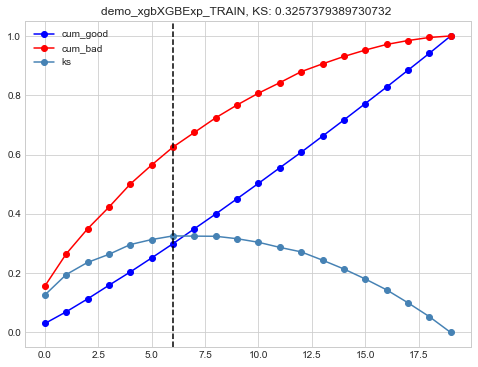

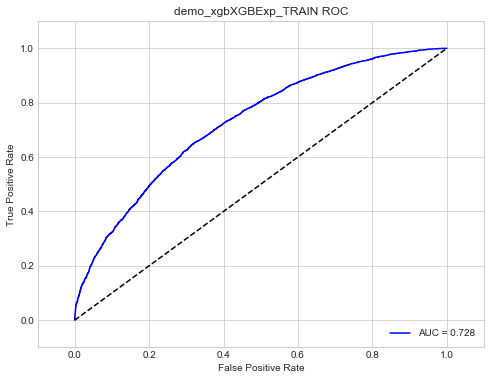

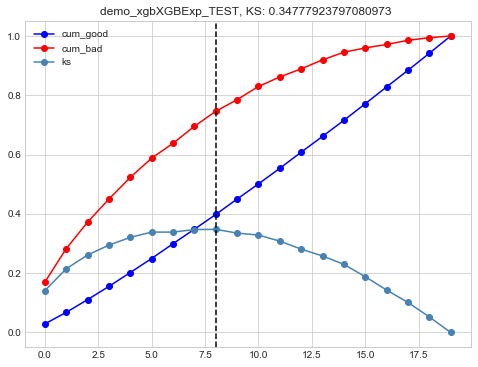

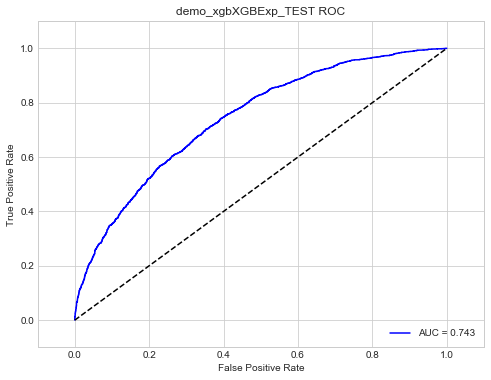

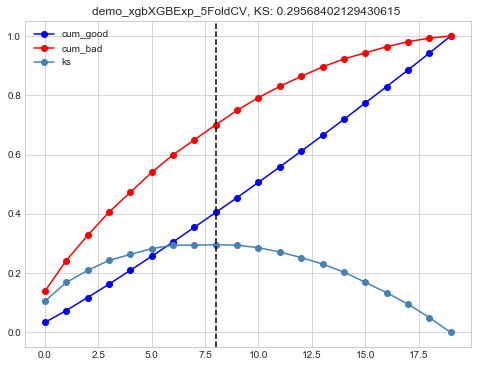

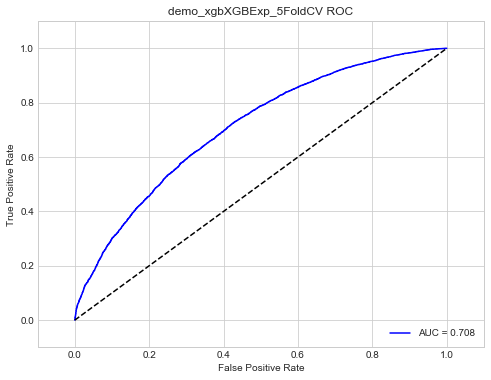

In [156]:
plot_obj.plot_for_the_model_sw(sample_weight,y,RESULT_PATH,model_result_exp, with_test=True)

### 查看XGBExp（经验参数）对应的每一颗决策树的决策点

In [157]:
model_result_exp['model_final'].dump_model(RESULT_PATH+'/model_result_exp_trees.txt')

### 查看XGBExp（经验参数）每一颗决策树对应的information和population

In [158]:
train_model_result_exp_leafs = ss.get_xgboost_tree_leaf_dist_and_badRate(model_result_exp\
                                                                         ,X_train_xgboost_with_bin_dummy,y_train,'y')

## 查看decile和Runbook

In [159]:
train_XGBExp_score = model_result_exp['p_train'].apply(mt.Performance().p_to_score)
test_XGBExp_score = model_result_exp['p_test'].apply(mt.Performance().p_to_score)

In [160]:
# 训练集
ks_decile_XGBExp_train = vp.get_decile_sw(train_XGBExp_score, sample_weight,y, 'decile',manual_cut_bounds=[])[1]
ks_decile_XGBExp_train

,分箱,样本数,好样本数,坏样本数,逾期率,Bad分布占比,Good分布占比,累积Bad占比,累积Good占比,KS,odds(good:bad)
0,"(-inf, 468.0]",10419.86,6123.73,4296.13,0.412302,0.263656,0.068699,0.263656,0.068699,1.949571e-01,1.425406
1,"(468.0, 496.0]",10552.17,7972.51,2579.66,0.244467,0.158315,0.089439,0.421971,0.158138,2.638331e-01,3.090527
2,"(496.0, 522.0]",10557.85,8240.75,2317.10,0.219467,0.142202,0.092448,0.564173,0.250586,3.135864e-01,3.556493
3,"(522.0, 545.0]",10553.33,8762.07,1791.26,0.169734,0.109931,0.098297,0.674103,0.348883,3.252202e-01,4.891568
4,"(545.0, 569.0]",10575.95,9061.42,1514.53,0.143205,0.092948,0.101655,0.767051,0.450538,3.165126e-01,5.982991
5,"(569.0, 594.0]",10376.81,9171.85,1204.96,0.116120,0.073949,0.102894,0.841000,0.553432,2.875678e-01,7.611746
6,"(594.0, 621.0]",10663.34,9617.28,1046.06,0.098099,0.064197,0.107891,0.905197,0.661323,2.438741e-01,9.193813
7,"(621.0, 651.0]",10456.95,9687.17,769.78,0.073614,0.047242,0.108675,0.952439,0.769998,1.824409e-01,12.584336
8,"(651.0, 693.0]",10613.66,10096.41,517.25,0.048734,0.031744,0.113266,0.984183,0.883264,1.009188e-01,19.519401
9,"(693.0, inf]",10663.43,10405.70,257.73,0.024170,0.015817,0.116736,1.000000,1.000000,1.110223e-16,40.374423


In [162]:
# 测试集
point_bounds_XGBExp = vp.get_decile_sw(train_XGBExp_score, sample_weight,y, 'decile',manual_cut_bounds=[])[0]
ks_decile_XGBExp_test = vp.get_decile_sw(test_XGBExp_score, sample_weight,y, 'decile',manual_cut_bounds=point_bounds_XGBExp)[1]
ks_decile_XGBExp_test

,分箱,样本数,好样本数,坏样本数,逾期率,Bad分布占比,Good分布占比,累积Bad占比,累积Good占比,KS,odds(good:bad)
0,"(-inf, 468.0]",4173.70,2335.75,1837.95,0.440365,0.268826,0.059565,0.268826,0.059565,2.092608e-01,1.270845
1,"(468.0, 496.0]",4348.70,3262.49,1086.21,0.249778,0.158873,0.083198,0.427699,0.142763,2.849361e-01,3.003554
2,"(496.0, 522.0]",4573.32,3590.72,982.60,0.214855,0.143719,0.091568,0.571418,0.234331,3.370866e-01,3.654305
3,"(522.0, 545.0]",4573.21,3845.27,727.94,0.159175,0.106471,0.098060,0.677889,0.332391,3.454983e-01,5.282400
4,"(545.0, 569.0]",5098.75,4390.69,708.06,0.138869,0.103564,0.111969,0.781453,0.444359,3.370932e-01,6.201014
5,"(569.0, 594.0]",4583.58,4052.18,531.40,0.115936,0.077725,0.103336,0.859177,0.547695,3.114817e-01,7.625480
6,"(594.0, 621.0]",4684.18,4281.04,403.14,0.086064,0.058965,0.109172,0.918142,0.656868,2.612741e-01,10.619239
7,"(621.0, 651.0]",4521.69,4250.10,271.59,0.060064,0.039724,0.108383,0.957866,0.765251,1.926146e-01,15.648956
8,"(651.0, 693.0]",4632.67,4451.46,181.21,0.039116,0.026504,0.113518,0.984370,0.878770,1.056007e-01,24.565201
9,"(693.0, inf]",4860.74,4753.88,106.86,0.021984,0.015630,0.121230,1.000000,1.000000,2.220446e-16,44.486992


In [164]:
run_XGBExp_book = vp.get_decile_sw(pd.concat([train_XGBExp_score,test_XGBExp_score],join='outer'),sample_weight,y, 'runbook',manual_cut_bounds=[])[1]

In [165]:
run_XGBExp_book

,分箱,样本数,好样本数,坏样本数,逾期率,Bad分布占比,Good分布占比,累积Bad占比,累积Good占比,KS,odds(good:bad)
0,"(-inf, 444.0]",7562.52,3853.78,3708.74,0.490411,0.160333,0.030025,0.160333,0.030025,1.303085e-01,1.039108
1,"(444.0, 469.0]",7551.72,4998.63,2553.09,0.338081,0.110373,0.038945,0.270707,0.068970,2.017372e-01,1.957875
2,"(469.0, 483.0]",6893.71,5075.31,1818.40,0.263777,0.078612,0.039542,0.349318,0.108512,2.408069e-01,2.791086
3,"(483.0, 497.0]",7973.86,6140.55,1833.31,0.229915,0.079256,0.047841,0.428575,0.156353,2.722218e-01,3.349434
4,"(497.0, 511.0]",7825.79,5993.91,1831.88,0.234082,0.079194,0.046699,0.507769,0.203052,3.047174e-01,3.271999
5,"(511.0, 523.0]",7601.74,6148.49,1453.25,0.191173,0.062826,0.047903,0.570595,0.250955,3.196401e-01,4.230855
6,"(523.0, 534.0]",6878.57,5660.16,1218.41,0.177131,0.052673,0.044099,0.623268,0.295053,3.282149e-01,4.645530
7,"(534.0, 546.0]",8292.12,6997.38,1294.74,0.156141,0.055973,0.054517,0.679241,0.349570,3.296712e-01,5.404467
8,"(546.0, 558.0]",7465.90,6303.78,1162.12,0.155657,0.050240,0.049113,0.729481,0.398683,3.307980e-01,5.424380
9,"(558.0, 569.0]",7380.91,6413.41,967.50,0.131081,0.041826,0.049967,0.771308,0.448651,3.226571e-01,6.628848


# OOT数据验证

## OOT数据增加sample_weight

In [168]:
OOT_data=all_x_y[all_x_y['sample_set']=='OOT']

In [169]:
sample_weight_oot={'Bad Channel':{'good_sample':8.64,'bad_sample':1},\
               'Good Channel':{'good_sample':14.27,'bad_sample':1},\
              'Normal Channel':{'good_sample':17.88,'bad_sample':1.2}}

In [170]:
OOT_data=mt.BinWoe().add_sample_weight(OOT_data,segment_label,sample_weight_oot)

In [171]:
OOT_data.index=OOT_data['apply_id']

In [172]:
oot_y=OOT_data['y']
sample_weight_oot=OOT_data['sample_weight']

In [174]:
data_OOT_final_selected = OOT_data[selected_final]
X_cat_OOT = bin_obj.convert_to_category(data_OOT_final_selected, var_dict, rebin_spec_bin_adjusted_final)

In [175]:
data_OOT_final_xgboost = mt.BinWoe().apply_xgboost_data_derive(data_OOT_final_selected,
                                var_dict, rebin_spec_bin_adjusted_final, bin_to_label)

In [176]:
X_OOT_xgboost_with_bin_dummy = bin_obj.convert_xgboost_rebins_to_dummy(data_OOT_final_xgboost,X_cat_OOT\
                                                                        ,dummy_var_name_map,is_apply=True)

In [178]:
X_OOT_xgboost_with_bin_dummy['xy_behaviorSuccessPayNumL1M_bin_dummy4']=0

In [179]:
data_OOT_XGBExp_p_score = mt.Performance().calculate_score_by_xgb_model_result\
(X_OOT_xgboost_with_bin_dummy, model_result_exp)

In [180]:
data_OOT_XGBExp = pd.merge(OOT_data,data_OOT_XGBExp_p_score\
                           ,left_index=True,right_index=True)

In [185]:
# 生成runbook
run_book_yzd_yyq_XGBExp_OOT = vp.get_decile_sw(data_OOT_XGBExp.xgbScore,sample_weight_oot\
,data_OOT_XGBExp.y, 'runbook',manual_cut_bounds=[])[1]

In [186]:
run_book_yzd_yyq_XGBExp_OOT

,分箱,样本数,好样本数,坏样本数,逾期率,Bad分布占比,Good分布占比,累积Bad占比,累积Good占比,KS,odds(good:bad)
0,"(-inf, 492.0]",879.71,765.11,114.6,0.130270,0.107565,0.044799,0.107565,0.044799,0.062766,6.676353
1,"(492.0, 517.0]",929.08,847.68,81.4,0.087614,0.076403,0.049634,0.183968,0.094433,0.089536,10.413759
2,"(517.0, 537.0]",864.82,792.62,72.2,0.083486,0.067768,0.046410,0.251736,0.140843,0.110894,10.978116
3,"(537.0, 556.0]",934.86,841.66,93.2,0.099694,0.087479,0.049281,0.339215,0.190124,0.149091,9.030687
4,"(556.0, 570.0]",808.34,726.34,82.0,0.101442,0.076966,0.042529,0.416182,0.232653,0.183529,8.857805
5,"(570.0, 581.0]",987.97,914.17,73.8,0.074699,0.069270,0.053527,0.485451,0.286180,0.199272,12.387127
6,"(581.0, 591.0]",939.68,888.68,51.0,0.054274,0.047869,0.052034,0.533321,0.338214,0.195107,17.425098
7,"(591.0, 601.0]",907.66,846.86,60.8,0.066985,0.057068,0.049586,0.590389,0.387800,0.202589,13.928618
8,"(601.0, 609.0]",910.97,865.77,45.2,0.049617,0.042425,0.050693,0.632814,0.438493,0.194321,19.154204
9,"(609.0, 616.0]",905.16,866.76,38.4,0.042423,0.036043,0.050751,0.668857,0.489244,0.179613,22.571875


In [188]:
# 生成decile
ks_decile_OOT_XGBExp_yzd_yyq = vp.get_decile_sw(data_OOT_XGBExp.xgbScore\
                                                         ,sample_weight_oot, data_OOT_XGBExp.y, 'decile', \
                                                         manual_cut_bounds=point_bounds_XGBExp)[1]
ks_decile_OOT_XGBExp_yzd_yyq

,分箱,样本数,好样本数,坏样本数,逾期率,Bad分布占比,Good分布占比,累积Bad占比,累积Good占比,KS,odds(good:bad)
0,"(-inf, 468.0]",529.96,471.16,58.8,0.110952,0.055191,0.027588,0.055191,0.027588,2.760296e-02,8.012925
1,"(468.0, 496.0]",465.82,397.02,68.8,0.147697,0.064577,0.023247,0.119767,0.050834,6.893314e-02,5.770640
2,"(496.0, 522.0]",1002.61,917.61,85.0,0.084779,0.079782,0.053728,0.199549,0.104562,9.498706e-02,10.795412
3,"(522.0, 545.0]",961.53,860.53,101.0,0.105041,0.094800,0.050386,0.294350,0.154949,1.394010e-01,8.520099
4,"(545.0, 569.0]",1365.50,1241.30,124.2,0.090956,0.116576,0.072681,0.410925,0.227630,1.832957e-01,9.994364
5,"(569.0, 594.0]",2351.26,2202.66,148.6,0.063200,0.139478,0.128971,0.550404,0.356601,1.938027e-01,14.822746
6,"(594.0, 621.0]",2829.06,2677.86,151.2,0.053445,0.141919,0.156795,0.692322,0.513396,1.789259e-01,17.710714
7,"(621.0, 651.0]",2414.54,2294.34,120.2,0.049782,0.112821,0.134339,0.805144,0.647735,1.574081e-01,19.087687
8,"(651.0, 693.0]",2833.80,2707.00,126.8,0.044746,0.119016,0.158502,0.924160,0.806237,1.179229e-01,21.348580
9,"(693.0, inf]",3390.02,3309.22,80.8,0.023835,0.075840,0.193763,1.000000,1.000000,-1.110223e-16,40.955693


# OOT PSI以及ranking验证

## OOT样本每个变量的ranking

In [196]:
# 合并y数据为后续统计做准备
data_OOT_final_xgboost_yzd_yyq_with_y = pd.merge(data_OOT_XGBExp\
                                                 ,OOT_data[['y']],left_index=True,right_index=True)

In [193]:
score_ranking_train_vs_oot_XGBExp = mt.Performance().score_ranking_psi_train_vs_oot\
(ks_decile_XGBExp_train,ks_decile_OOT_XGBExp_yzd_yyq)

In [194]:
score_ranking_train_vs_oot_XGBExp

,分箱,train_set样本量,train_set逾期率,train_set分布占比,OOT_set样本量,OOT_set逾期率,OOT_set分布占比,数据源,指标英文,指标中文,指标类型,分箱对应原始分类,PSI
0,"(-inf, 468.0]",10419.86,0.412302,0.098829,529.96,0.110952,0.029208,模型分,modelScore,模型分,/,None,0.084863
1,"(468.0, 496.0]",10552.17,0.244467,0.100084,465.82,0.147697,0.025673,模型分,modelScore,模型分,/,None,0.101239
2,"(496.0, 522.0]",10557.85,0.219467,0.100138,1002.61,0.084779,0.055258,模型分,modelScore,模型分,/,None,0.026682
3,"(522.0, 545.0]",10553.33,0.169734,0.100095,961.53,0.105041,0.052994,模型分,modelScore,模型分,/,None,0.029953
4,"(545.0, 569.0]",10575.95,0.143205,0.100309,1365.50,0.090956,0.075259,模型分,modelScore,模型分,/,None,0.007198
5,"(569.0, 594.0]",10376.81,0.116120,0.098421,2351.26,0.063200,0.129588,模型分,modelScore,模型分,/,None,0.008575
6,"(594.0, 621.0]",10663.34,0.098099,0.101138,2829.06,0.053445,0.155922,模型分,modelScore,模型分,/,None,0.023714
7,"(621.0, 651.0]",10456.95,0.073614,0.099181,2414.54,0.049782,0.133076,模型分,modelScore,模型分,/,None,0.009964
8,"(651.0, 693.0]",10613.66,0.048734,0.100667,2833.80,0.044746,0.156183,模型分,modelScore,模型分,/,None,0.024383
9,"(693.0, inf]",10663.43,0.024170,0.101139,3390.02,0.023835,0.186839,模型分,modelScore,模型分,/,None,0.052598


In [198]:
oot_model_result_exp_leafs = ss.get_xgboost_tree_leaf_dist_and_badRate(model_result_exp\
                                                                       ,X_OOT_xgboost_with_bin_dummy\
                                                                       ,oot_y,'y')

In [200]:
train_oot_leafs_exp_psi_badRate = ss.compare_train_OOT_leaf_psi_and_badRate(train_model_result_exp_leafs,'train',\
                                                                       oot_model_result_exp_leafs,'oot')

# 模型部署

In [201]:
import utils3.deploy as dp 

## 生成XGBExp模型部署文档

In [203]:
# 引入模型的分箱明细
model_spec = load_data_from_pickle(DATA_PATH,'%s_XGBoost输出数据和分箱明细.pkl' % 'demo_xgb')

In [207]:
xgb_importance_Exp = pd.read_excel(RESULT_PATH+'/demo_xgbXGBExp模型变量重要性排序.xlsx')

In [209]:
# shift+table查看每个参数含义
dp.generate_xgb_deployment_documents('demoEXP', 'EXPhasoverdue', summary,model_spec,xgb_importance_Exp,
                                      var_dict,ks_decile_XGBExp_train,model_result_exp,RESULT_PATH
                                      , production_name_map={'riskGrade':'rg'})

In [210]:
pd.Series(model_result_exp['model_final'].get_fscore())\
.to_frame('importance').sort_values(by='importance',ascending=False)

,importance
xy_behaviorFailPayNumHist,75
tongdun12MIdMultiLoanNumPf,54
tencentScore_new,53
nike700Score,39
ym_credit_score_big,38
br_grzz_pc_rcnt_income,34
tongdun6MIdXiaofeiFenqiLoanNum,24
tongdunPhoneMultiLoanNum_v2,24
tongdunotherNumPfL3M,22
tongdunP2PNumPfL3M,21


# 模型文档整理

In [211]:
FINAL_REPORT_PATH = '/Users/zhenwei.jin/Desktop/sample_weight/logistic/03_result/result'

In [212]:
import utils3.filing as fl
reload(fl)

<module 'utils3.filing' from '/Users/zhenwei.jin/Documents/repos/genie/utils3/filing.py'>

In [215]:
# python3.6的dict是ordered，按照顺序这样定义，之后生成excel的时候会按照顺序穿件sheet
data_dic = {}
# 如果sheet对应的内容是dict，则dict的key会出现在sheet第一列。value会从第二列开始插入
data_dic['01_模型结果'] = {
    '样本统计': sample_split_summary,
    #如果是图片的话必须key值中包含'_picture'，然后value为figure_path下面的图存储路径和文件名 
    'XGBExp_TRAIN_KS_picture': 'KS/demo_xgbXGBExp_TRAIN_KS.png',
    'XGBExp_TEST_KS_picture': 'KS/demo_xgbXGBExp_TEST_KS.png',
    'XGBExp_CV5_KS_picture': 'KS/demo_xgbXGBExp_5FoldCV_KS.png'
}
data_dic['02_EDA'] = summary
data_dic['03_模型细分箱'] = woe_iv_df
data_dic['04_模型粗分箱'] = woe_iv_df_coarse
data_dic['05_决策参考'] = {'XGBExp_train_decile':ks_decile_XGBExp_train,
                          'XGBExp_test_decile':ks_decile_XGBExp_test,
                      'XGBExp_runbook':run_XGBExp_book
                      }

data_dic['06_OOT统计'] = {'XGBExp_oot_runbook':ks_decile_OOT_XGBExp_yzd_yyq,
                       'XGBExp_oot_PSI':score_ranking_train_vs_oot_XGBExp
                       }
data_dic['07_leafs_OOT统计'] = {'train_oot_leafs_exp_psi_badRate':train_oot_leafs_exp_psi_badRate
                       }
# 如果sheet对应的内容是df，则从sheet的A1位置开始插入整张表格，不包含pd.DataFrame的index
data_dic['细节1_变量按时间分布以及逾期率'] = var_dist_badRate_by_time



In [216]:
fl.ModelSummary2Excel(FINAL_REPORT_PATH, os.path.join(RESULT_PATH, 'figure'), 
                   'DEMO_XGB_sample_weight模型文档.xlsx', data_dic).run()